In [82]:
import os
import cv2
import numpy as np
from pathlib import Path
from tqdm import tqdm

# Input and output directories
base_input_dir = '/Users/unar/Downloads/Data'
processed_output_dir = '/Users/unar/Downloads/ct_scan_1_processed_44'

splits = ['train', 'valid', 'test']
classes = ['normal', 'adenocarcinoma', 'large.cell.carcinoma', 'squamous.cell.carcinoma']

# Preprocessing functions
def apply_median_filter(img):
    return cv2.medianBlur(img, 3)

def apply_histogram_equalization(img):
    if len(img.shape) == 2:
        return cv2.equalizeHist(img)
    else:
        img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
        return cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

def apply_clahe(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    if len(img.shape) == 2:
        return clahe.apply(img)
    else:
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        l = clahe.apply(l)
        merged = cv2.merge((l, a, b))
        return cv2.cvtColor(merged, cv2.COLOR_LAB2BGR)

def apply_morphological_ops(img):
    kernel = np.ones((3, 3), np.uint8)
    return cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)

# Processing
for split in splits:
    for cls in classes:
        input_dir = os.path.join(base_input_dir, split, cls)
        output_dir = os.path.join(processed_output_dir, split, cls)
        os.makedirs(output_dir, exist_ok=True)

        if not os.path.exists(input_dir):
            print(f"[Warning] {input_dir} does not exist!")
            continue

        # Accept common image formats
        valid_exts = ['.jpg', '.jpeg', '.png']
        image_files = [p for p in Path(input_dir).rglob('*') if p.suffix.lower() in valid_exts]

        skipped = 0
        for img_path in tqdm(image_files, desc=f'Processing {split}/{cls}'):
            try:
                img = cv2.imread(str(img_path))
                if img is None:
                    skipped += 1
                    continue

                img = apply_median_filter(img)
                img = apply_histogram_equalization(img)
                img = apply_clahe(img)
                img = apply_morphological_ops(img)

                save_path = os.path.join(output_dir, os.path.basename(img_path))
                success = cv2.imwrite(save_path, img)
                if not success:
                    skipped += 1

            except Exception as e:
                skipped += 1
                print(f"[Error] {img_path}: {e}")

        print(f"[{split}/{cls}] Skipped {skipped} images.")

Processing train/normal: 100%|████████████████| 148/148 [00:01<00:00, 98.58it/s]


[train/normal] Skipped 0 images.


Processing train/adenocarcinoma: 100%|███████| 195/195 [00:00<00:00, 224.08it/s]


[train/adenocarcinoma] Skipped 0 images.


Processing train/large.cell.carcinoma: 100%|█| 115/115 [00:00<00:00, 233.92it/s]


[train/large.cell.carcinoma] Skipped 0 images.


Processing train/squamous.cell.carcinoma: 100%|█| 155/155 [00:00<00:00, 224.15it


[train/squamous.cell.carcinoma] Skipped 0 images.


Processing valid/normal: 100%|██████████████████| 13/13 [00:00<00:00, 78.26it/s]


[valid/normal] Skipped 0 images.


Processing valid/adenocarcinoma: 100%|█████████| 23/23 [00:00<00:00, 256.87it/s]


[valid/adenocarcinoma] Skipped 0 images.


Processing valid/large.cell.carcinoma: 100%|███| 21/21 [00:00<00:00, 257.51it/s]


[valid/large.cell.carcinoma] Skipped 0 images.


Processing valid/squamous.cell.carcinoma: 100%|█| 15/15 [00:00<00:00, 240.96it/s


[valid/squamous.cell.carcinoma] Skipped 0 images.


Processing test/normal: 100%|███████████████████| 54/54 [00:00<00:00, 86.42it/s]


[test/normal] Skipped 0 images.


Processing test/adenocarcinoma: 100%|████████| 120/120 [00:00<00:00, 187.79it/s]


[test/adenocarcinoma] Skipped 0 images.


Processing test/large.cell.carcinoma: 100%|████| 51/51 [00:00<00:00, 209.50it/s]


[test/large.cell.carcinoma] Skipped 0 images.


Processing test/squamous.cell.carcinoma: 100%|█| 90/90 [00:00<00:00, 182.24it/s]

[test/squamous.cell.carcinoma] Skipped 0 images.


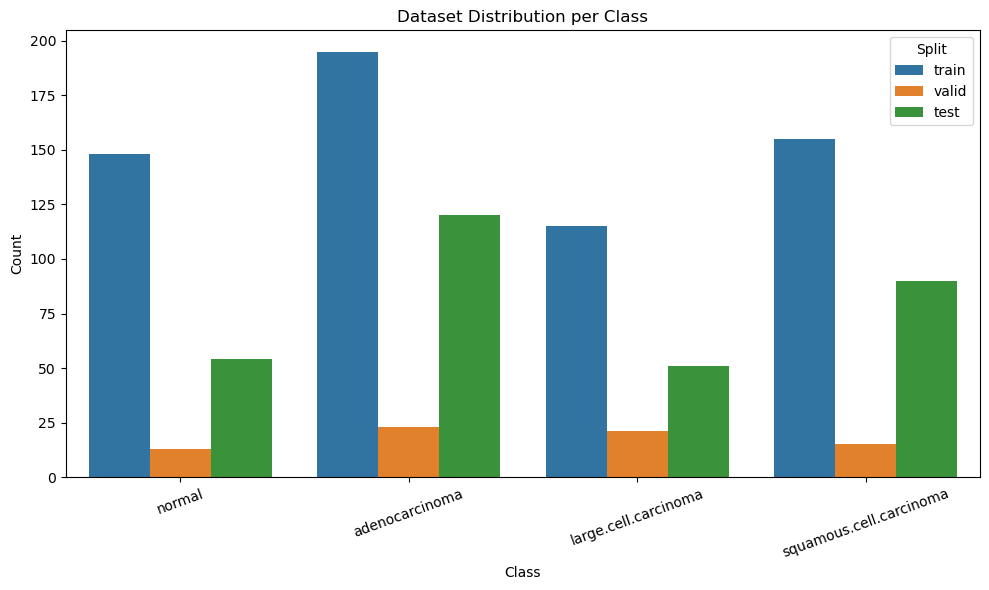

In [83]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Base directory
base_input_dir = '/Users/unar/Downloads/ct_scan_1_processed_45'  # or original if you want

splits = ['train', 'valid', 'test']
classes = ['normal', 'adenocarcinoma', 'large.cell.carcinoma', 'squamous.cell.carcinoma']

# Count images per class per split
data_counts = defaultdict(dict)

for split in splits:
    for cls in classes:
        dir_path = os.path.join(base_input_dir, split, cls)
        if not os.path.exists(dir_path):
            data_counts[split][cls] = 0
            continue
        count = len([f for f in os.listdir(dir_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        data_counts[split][cls] = count

# Prepare for plot
plot_data = []
for split in splits:
    for cls in classes:
        plot_data.append({'Split': split, 'Class': cls, 'Count': data_counts[split][cls]})

import pandas as pd
df = pd.DataFrame(plot_data)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='Class', y='Count', hue='Split')
plt.title('Dataset Distribution per Class')
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

In [84]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Dataset paths
train_folder = '/Users/unar/Downloads/ct_scan_1_processed_45/train'
val_folder = '/Users/unar/Downloads/ct_scan_1_processed_45/valid'
test_folder = '/Users/unar/Downloads/ct_scan_1_processed_45/test'

# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 4  # Based on the 4 folders

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_folder,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = val_test_datagen.flow_from_directory(
    val_folder,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_gen = val_test_datagen.flow_from_directory(
    test_folder,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Load base ResNet50


Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [99]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze top layers for fine-tuning
for layer in base_model.layers[:143]:  # Freeze early layers
    layer.trainable = False
for layer in base_model.layers[143:]:
    layer.trainable = True

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint("resnet50_lung_ct_proj.h5", monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True)

# Train the model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=25,
    callbacks=[checkpoint, early_stop]
)

# Evaluate
loss, acc = model.evaluate(test_gen)
print(f"\n✅ ResNet50 Test Accuracy: {acc * 100:.2f}%")

Epoch 1/25


2025-04-14 23:09:56.170469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - ETA: 0s - loss: 1.4409 - accuracy: 0.3442

2025-04-14 23:10:03.296319: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.31944, saving model to resnet50_lung_ct_proj.h5


/Users/unar/env/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 10s 402ms/step - loss: 1.4409 - accuracy: 0.3442 - val_loss: 2.0144 - val_accuracy: 0.3194
Epoch 2/25
20/20 [==============================] - ETA: 0s - loss: 1.2644 - accuracy: 0.4078
Epoch 2: val_accuracy did not improve from 0.31944
20/20 [==============================] - 6s 273ms/step - loss: 1.2644 - accuracy: 0.4078 - val_loss: 1.7716 - val_accuracy: 0.3194
Epoch 3/25
20/20 [==============================] - ETA: 0s - loss: 1.1629 - accuracy: 0.4617
Epoch 3: val_accuracy did not improve from 0.31944
20/20 [==============================] - 6s 283ms/step - loss: 1.1629 - accuracy: 0.4617 - val_loss: 1.6212 - val_accuracy: 0.3194
Epoch 4/25
20/20 [==============================] - ETA: 0s - loss: 1.1210 - accuracy: 0.4812
Epoch 4: val_accuracy did not improve from 0.31944
20/20 [==============================] - 6s 290ms/step - loss: 1.1210 - accuracy: 0.4812 - val_loss: 1.4987 - val_accuracy: 0.3194
Epoch 5/25
20/20 [======================

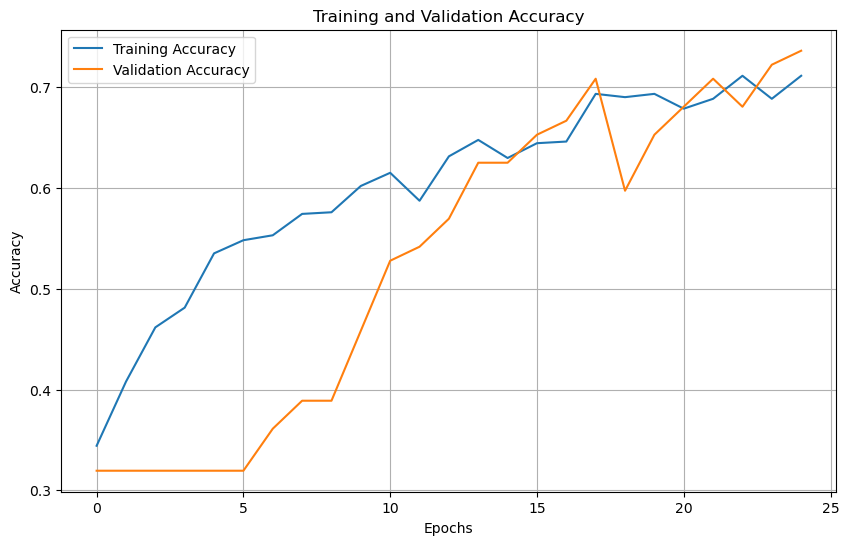

2025-04-14 23:14:10.870830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 3s 211ms/step


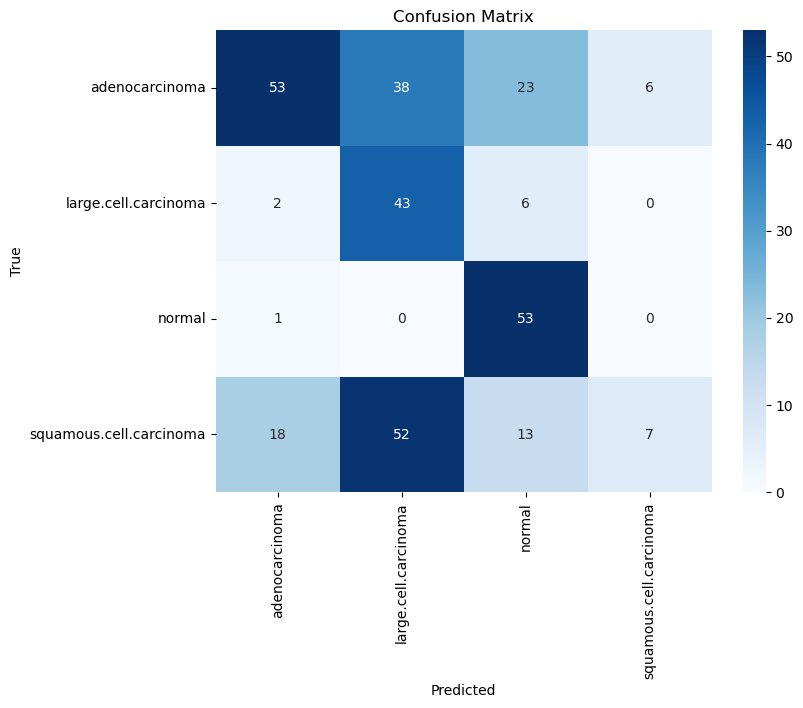

Classification Report:
                         precision    recall  f1-score   support

         adenocarcinoma       0.72      0.44      0.55       120
   large.cell.carcinoma       0.32      0.84      0.47        51
                 normal       0.56      0.98      0.71        54
squamous.cell.carcinoma       0.54      0.08      0.14        90

               accuracy                           0.50       315
              macro avg       0.53      0.59      0.47       315
           weighted avg       0.57      0.50      0.44       315



In [100]:
history_dict = history.history
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

plt.figure(figsize=(10, 6))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# 2. Confusion Matrix
# Predict on the test set
y_true = test_gen.classes  # true labels
y_pred = model.predict(test_gen, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get class with highest probability

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=test_gen.class_indices, yticklabels=test_gen.class_indices)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# 3. Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=test_gen.class_indices.keys()))

In [109]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(train_gen.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=8, factor=0.2, min_lr=1e-6)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=25,
    callbacks=callbacks
)
loss, acc = model.evaluate(test_gen)
print(f"Test Accuracy: {acc * 100:.2f}%")
model.save('/Users/unar/Downloads/mobilenetv2_ctUU_project_model')
print("✅ Model saved in 'mobilenetv2_ct_model/' directory")

Epoch 1/25


2025-04-14 23:24:37.500420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - ETA: 0s - loss: 2.2557 - accuracy: 0.3638

2025-04-14 23:24:43.177472: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 14s 291ms/step - loss: 2.2557 - accuracy: 0.3638 - val_loss: 1.7587 - val_accuracy: 0.4028 - lr: 0.0010
Epoch 2/25
20/20 [==============================] - 4s 211ms/step - loss: 1.7232 - accuracy: 0.4845 - val_loss: 1.2499 - val_accuracy: 0.4861 - lr: 0.0010
Epoch 3/25
20/20 [==============================] - 4s 211ms/step - loss: 1.3222 - accuracy: 0.5530 - val_loss: 1.0965 - val_accuracy: 0.5139 - lr: 0.0010
Epoch 4/25
20/20 [==============================] - 4s 202ms/step - loss: 1.3224 - accuracy: 0.5530 - val_loss: 1.1689 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/25
20/20 [==============================] - 4s 203ms/step - loss: 1.0665 - accuracy: 0.5840 - val_loss: 1.1447 - val_accuracy: 0.4861 - lr: 0.0010
Epoch 6/25
20/20 [==============================] - 4s 205ms/step - loss: 1.0856 - accuracy: 0.6117 - val_loss: 1.2331 - val_accuracy: 0.5694 - lr: 0.0010
Epoch 7/25
20/20 [==============================] - 4s 210ms/step - loss: 0.8964

INFO:tensorflow:Assets written to: /Users/unar/Downloads/mobilenetv2_ctUU_project_model/assets


✅ Model saved in 'mobilenetv2_ct_model/' directory


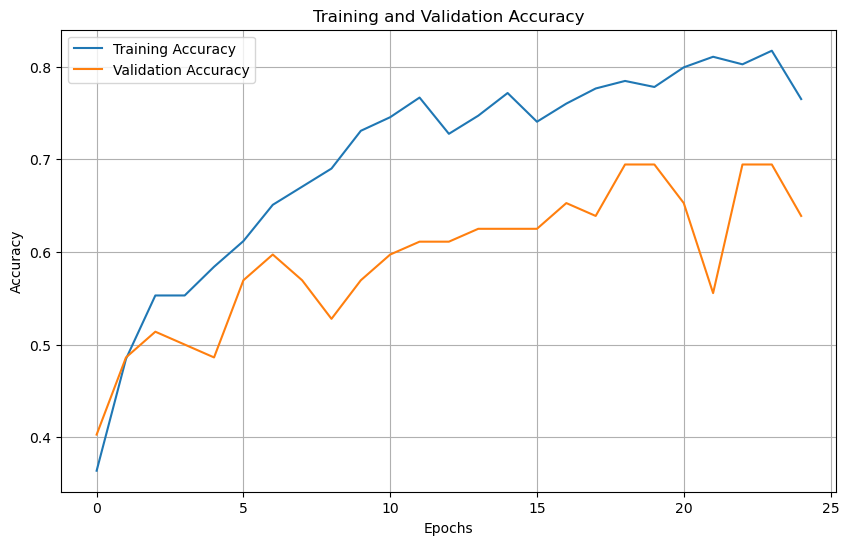

2025-04-14 23:26:35.073908: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 2s 129ms/step


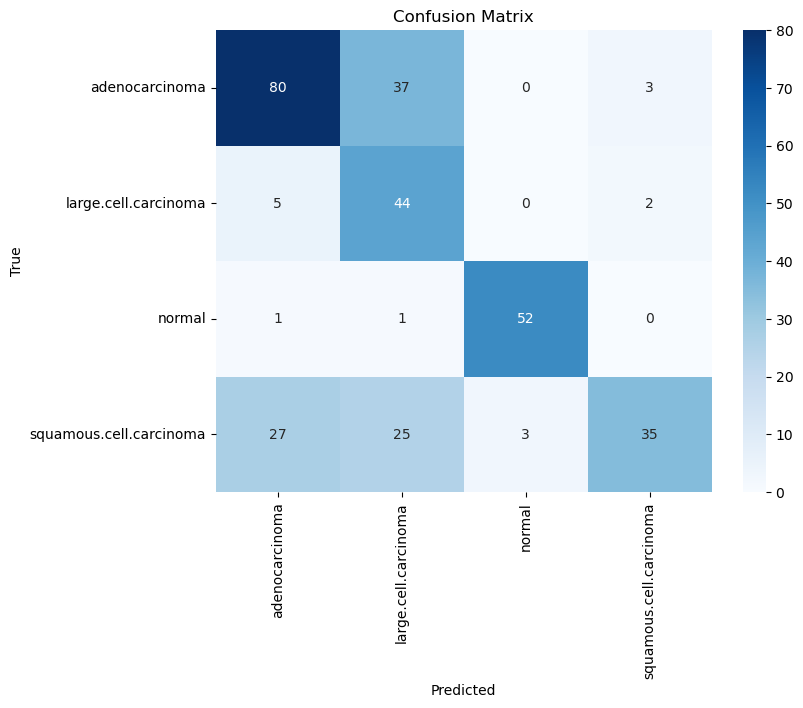

Classification Report:
                         precision    recall  f1-score   support

         adenocarcinoma       0.71      0.67      0.69       120
   large.cell.carcinoma       0.41      0.86      0.56        51
                 normal       0.95      0.96      0.95        54
squamous.cell.carcinoma       0.88      0.39      0.54        90

               accuracy                           0.67       315
              macro avg       0.73      0.72      0.68       315
           weighted avg       0.75      0.67      0.67       315



In [110]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# 1. Plot Training and Validation Accuracy
history_dict = history.history
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

plt.figure(figsize=(10, 6))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# 2. Confusion Matrix
# Predict on the test set
y_true = test_gen.classes  # true labels
y_pred = model.predict(test_gen, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get class with highest probability

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=test_gen.class_indices, yticklabels=test_gen.class_indices)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# 3. Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=test_gen.class_indices.keys()))

In [87]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base for now

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint("densenet121_ct_best_proj.h5", monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True)

# Train base model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=25,
    callbacks=[checkpoint, early_stop]
)
#Evaluate
loss, acc = model.evaluate(test_gen)
print(f"\n✅ densenet121 Test Accuracy: {acc * 100:.2f}%")

Epoch 1/25


2025-04-14 22:59:44.937253: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - ETA: 0s - loss: 1.5497 - accuracy: 0.4649

2025-04-14 22:59:56.632207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.18056, saving model to densenet121_ct_best_proj.h5


/Users/unar/env/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 20s 708ms/step - loss: 1.5497 - accuracy: 0.4649 - val_loss: 5.5504 - val_accuracy: 0.1806
Epoch 2/25
20/20 [==============================] - ETA: 0s - loss: 1.0389 - accuracy: 0.6395
Epoch 2: val_accuracy improved from 0.18056 to 0.20833, saving model to densenet121_ct_best_proj.h5
20/20 [==============================] - 10s 502ms/step - loss: 1.0389 - accuracy: 0.6395 - val_loss: 4.0627 - val_accuracy: 0.2083
Epoch 3/25
20/20 [==============================] - ETA: 0s - loss: 0.8458 - accuracy: 0.6917
Epoch 3: val_accuracy improved from 0.20833 to 0.31944, saving model to densenet121_ct_best_proj.h5
20/20 [==============================] - 10s 495ms/step - loss: 0.8458 - accuracy: 0.6917 - val_loss: 2.0341 - val_accuracy: 0.3194
Epoch 4/25
20/20 [==============================] - ETA: 0s - loss: 0.7527 - accuracy: 0.7276
Epoch 4: val_accuracy improved from 0.31944 to 0.50000, saving model to densenet121_ct_best_proj.h5
20/20 [===============

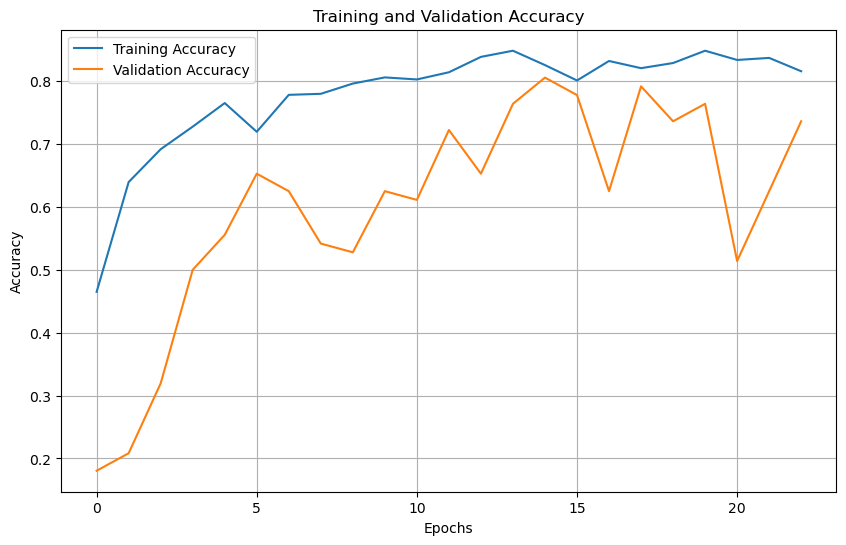

2025-04-14 23:03:27.289297: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 6s 452ms/step


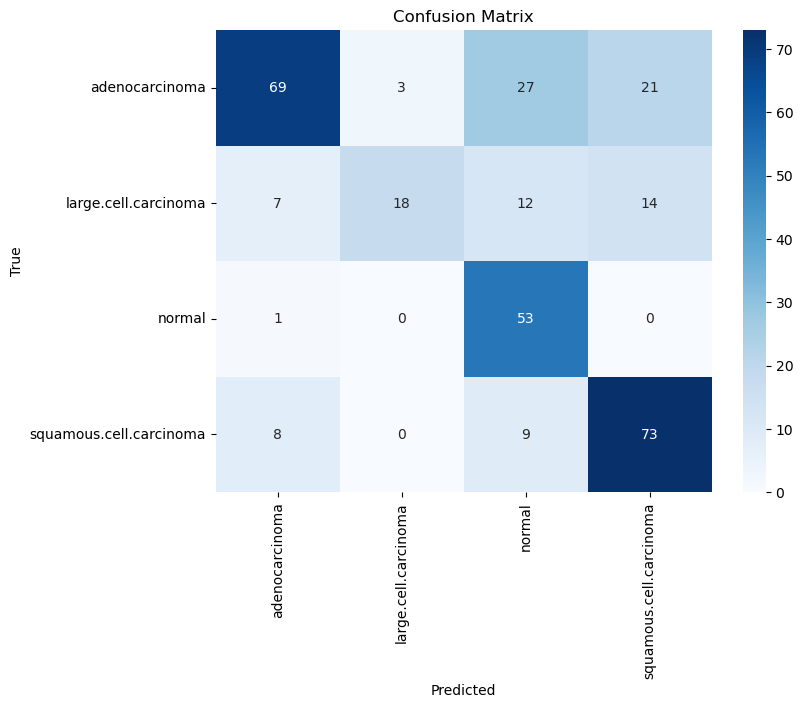

Classification Report:
                         precision    recall  f1-score   support

         adenocarcinoma       0.81      0.57      0.67       120
   large.cell.carcinoma       0.86      0.35      0.50        51
                 normal       0.52      0.98      0.68        54
squamous.cell.carcinoma       0.68      0.81      0.74        90

               accuracy                           0.68       315
              macro avg       0.72      0.68      0.65       315
           weighted avg       0.73      0.68      0.67       315



In [88]:
history_dict = history.history
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

plt.figure(figsize=(10, 6))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# 2. Confusion Matrix
# Predict on the test set
y_true = test_gen.classes  # true labels
y_pred = model.predict(test_gen, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get class with highest probability

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=test_gen.class_indices, yticklabels=test_gen.class_indices)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# 3. Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=test_gen.class_indices.keys()))

In [112]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in vgg_base.layers:
    layer.trainable = False  # Freeze pre-trained layers

# Add classification head
x = Flatten()(vgg_base.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=vgg_base.input, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Save best model
checkpoint = ModelCheckpoint("vgg16_ct_scan_model_prject.h5", monitor='val_accuracy', save_best_only=True)

# Train
model.fit(train_gen, validation_data=val_gen, epochs=25, callbacks=[checkpoint])

# Evaluate
loss, accuracy = model.evaluate(test_gen)
print(f"\n✅ Test Accuracy: {accuracy * 100:.2f}%")

Epoch 1/25


2025-04-14 23:31:39.178592: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - ETA: 0s - loss: 15.7156 - accuracy: 0.3051

2025-04-14 23:31:46.478313: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 9s 403ms/step - loss: 15.7156 - accuracy: 0.3051 - val_loss: 5.6158 - val_accuracy: 0.4861
Epoch 2/25
20/20 [==============================] - 7s 350ms/step - loss: 11.1675 - accuracy: 0.4111 - val_loss: 4.0693 - val_accuracy: 0.5000
Epoch 3/25
20/20 [==============================] - 7s 346ms/step - loss: 9.1591 - accuracy: 0.4649 - val_loss: 3.3120 - val_accuracy: 0.5417
Epoch 4/25
20/20 [==============================] - 7s 355ms/step - loss: 6.2422 - accuracy: 0.5008 - val_loss: 1.5027 - val_accuracy: 0.6667
Epoch 5/25
20/20 [==============================] - 8s 381ms/step - loss: 4.6563 - accuracy: 0.5449 - val_loss: 2.4364 - val_accuracy: 0.5694
Epoch 6/25
20/20 [==============================] - 8s 401ms/step - loss: 3.3999 - accuracy: 0.5742 - val_loss: 1.2532 - val_accuracy: 0.6944
Epoch 7/25
20/20 [==============================] - 9s 421ms/step - loss: 2.9243 - accuracy: 0.6003 - val_loss: 1.2255 - val_accuracy: 0.7083
Epoch 8/25
20/2

2025-04-14 23:35:41.767140: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 3s 277ms/step


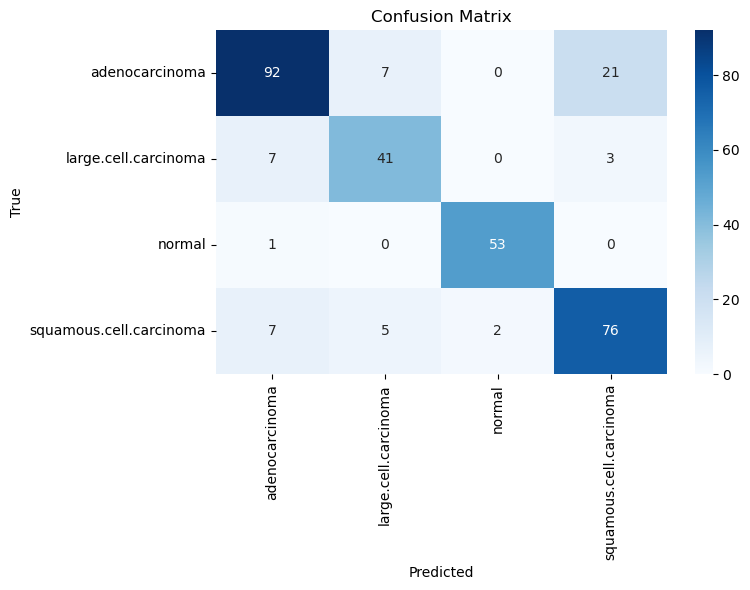


📋 Classification Report:

                         precision    recall  f1-score   support

         adenocarcinoma       0.86      0.77      0.81       120
   large.cell.carcinoma       0.77      0.80      0.79        51
                 normal       0.96      0.98      0.97        54
squamous.cell.carcinoma       0.76      0.84      0.80        90

               accuracy                           0.83       315
              macro avg       0.84      0.85      0.84       315
           weighted avg       0.84      0.83      0.83       315



In [113]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Get true labels and predictions
# Make sure test_gen is not shuffled so labels align
test_gen.reset()
Y_pred = model.predict(test_gen, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_gen.classes

# Step 2: Generate Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
class_labels = list(test_gen.class_indices.keys())

# Step 3: Plot it
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Step 4: Optional - Detailed Report
print("\n📋 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

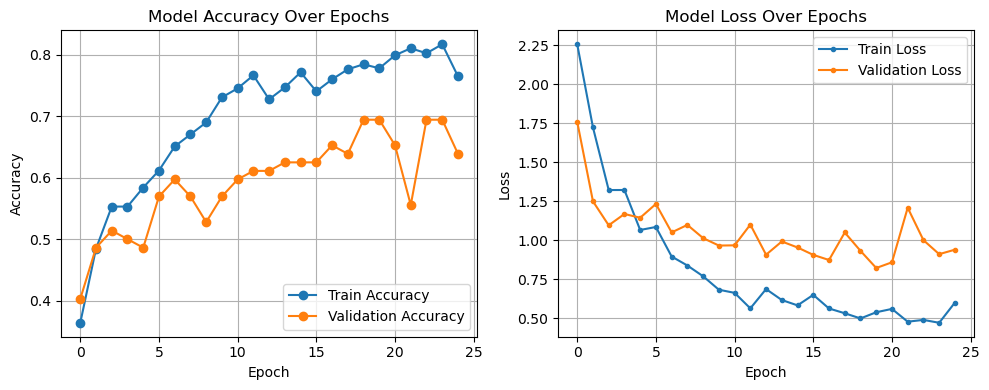

In [114]:
import matplotlib.pyplot as plt

# Accuracy
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='.')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='.')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [115]:
from tensorflow.keras.models import load_model

# Load the best saved model
model_VGG = load_model('vgg16_ct_scan_model_prject.h5')

# Evaluate


1/1 [==============================] - 0s 139ms/step


2025-04-14 23:35:55.953810: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


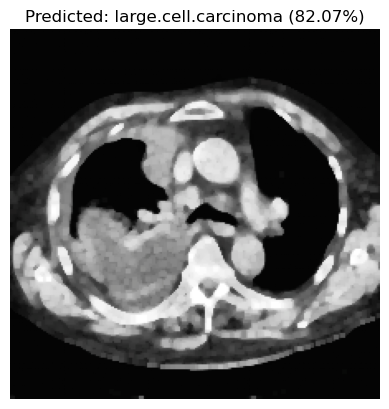

In [116]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# --- Custom Preprocessing Functions ---
def apply_median_filter(img):
    return cv2.medianBlur(img, 3)

def apply_histogram_equalization(img):
    if len(img.shape) == 2:
        return cv2.equalizeHist(img)
    else:
        img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)  # Image is in RGB from Keras
        img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
        return cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)

def apply_clahe(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    if len(img.shape) == 2:
        return clahe.apply(img)
    else:
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        l = clahe.apply(l)
        merged = cv2.merge((l, a, b))
        return cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)

def apply_morphological_ops(img):
    kernel = np.ones((3, 3), np.uint8)
    return cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)

# --- Load Image and Preprocess ---
img_path = '/Users/unar/Downloads/LLDS.png'  # Your test image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img).astype(np.uint8)
img_rgb = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)  # Ensuring RGB

# Apply preprocessing pipeline
processed_img = apply_median_filter(img_rgb)
processed_img = apply_histogram_equalization(processed_img)
processed_img = apply_clahe(processed_img)
processed_img = apply_morphological_ops(processed_img)

# Normalize and prepare for model
processed_img = processed_img / 255.0
img_batch = np.expand_dims(processed_img, axis=0)

# --- Predict ---
prediction = model_VGG.predict(img_batch)
predicted_class_index = np.argmax(prediction)
class_labels = list(train_gen.class_indices.keys())
predicted_class = class_labels[predicted_class_index]

# --- Display ---
plt.imshow(processed_img)
plt.axis('off')
plt.title(f"Predicted: {predicted_class} ({np.max(prediction)*100:.2f}%)")
plt.show()

1/1 [==============================] - 0s 13ms/step


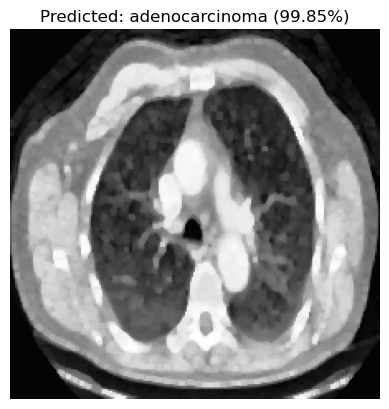

In [117]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# --- Custom Preprocessing Functions ---
def apply_median_filter(img):
    return cv2.medianBlur(img, 3)

def apply_histogram_equalization(img):
    if len(img.shape) == 2:
        return cv2.equalizeHist(img)
    else:
        img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)  # Image is in RGB from Keras
        img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
        return cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)

def apply_clahe(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    if len(img.shape) == 2:
        return clahe.apply(img)
    else:
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        l = clahe.apply(l)
        merged = cv2.merge((l, a, b))
        return cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)

def apply_morphological_ops(img):
    kernel = np.ones((3, 3), np.uint8)
    return cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)

# --- Load Image and Preprocess ---
img_path = '/Users/unar/Downloads/AD.png'  # Your test image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img).astype(np.uint8)
img_rgb = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)  # Ensuring RGB

# Apply preprocessing pipeline
processed_img = apply_median_filter(img_rgb)
processed_img = apply_histogram_equalization(processed_img)
processed_img = apply_clahe(processed_img)
processed_img = apply_morphological_ops(processed_img)

# Normalize and prepare for model
processed_img = processed_img / 255.0
img_batch = np.expand_dims(processed_img, axis=0)

# --- Predict ---
prediction = model_VGG.predict(img_batch)
predicted_class_index = np.argmax(prediction)
class_labels = list(train_gen.class_indices.keys())
predicted_class = class_labels[predicted_class_index]

# --- Display ---
plt.imshow(processed_img)
plt.axis('off')
plt.title(f"Predicted: {predicted_class} ({np.max(prediction)*100:.2f}%)")
plt.show()

1/1 [==============================] - 0s 15ms/step


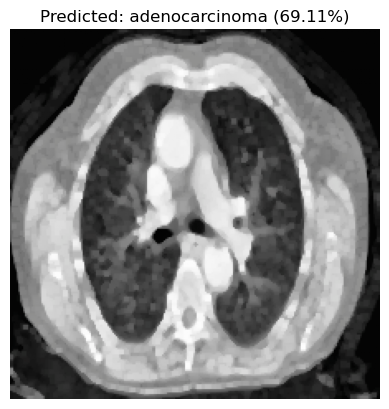

In [118]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# --- Custom Preprocessing Functions ---
def apply_median_filter(img):
    return cv2.medianBlur(img, 3)

def apply_histogram_equalization(img):
    if len(img.shape) == 2:
        return cv2.equalizeHist(img)
    else:
        img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)  # Image is in RGB from Keras
        img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
        return cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)

def apply_clahe(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    if len(img.shape) == 2:
        return clahe.apply(img)
    else:
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        l = clahe.apply(l)
        merged = cv2.merge((l, a, b))
        return cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)

def apply_morphological_ops(img):
    kernel = np.ones((3, 3), np.uint8)
    return cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)

# --- Load Image and Preprocess ---
img_path = '/Users/unar/Downloads/SC.png'  # Your test image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img).astype(np.uint8)
img_rgb = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)  # Ensuring RGB

# Apply preprocessing pipeline
processed_img = apply_median_filter(img_rgb)
processed_img = apply_histogram_equalization(processed_img)
processed_img = apply_clahe(processed_img)
processed_img = apply_morphological_ops(processed_img)

# Normalize and prepare for model
processed_img = processed_img / 255.0
img_batch = np.expand_dims(processed_img, axis=0)

# --- Predict ---
prediction = model_VGG.predict(img_batch)
predicted_class_index = np.argmax(prediction)
class_labels = list(train_gen.class_indices.keys())
predicted_class = class_labels[predicted_class_index]

# --- Display ---
plt.imshow(processed_img)
plt.axis('off')
plt.title(f"Predicted: {predicted_class} ({np.max(prediction)*100:.2f}%)")
plt.show()

1/1 [==============================] - 0s 17ms/step


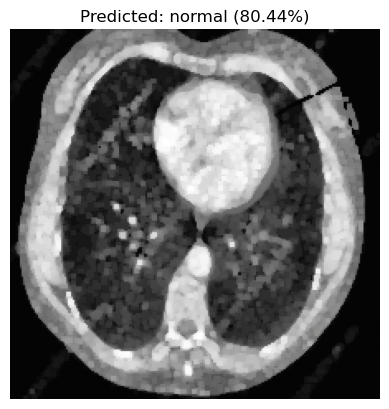

In [119]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# --- Custom Preprocessing Functions ---
def apply_median_filter(img):
    return cv2.medianBlur(img, 3)

def apply_histogram_equalization(img):
    if len(img.shape) == 2:
        return cv2.equalizeHist(img)
    else:
        img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)  # Image is in RGB from Keras
        img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
        return cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)

def apply_clahe(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    if len(img.shape) == 2:
        return clahe.apply(img)
    else:
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        l = clahe.apply(l)
        merged = cv2.merge((l, a, b))
        return cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)

def apply_morphological_ops(img):
    kernel = np.ones((3, 3), np.uint8)
    return cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)

# --- Load Image and Preprocess ---
img_path = '/Users/unar/Downloads/NRL.png'  # Your test image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img).astype(np.uint8)
img_rgb = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)  # Ensuring RGB

# Apply preprocessing pipeline
processed_img = apply_median_filter(img_rgb)
processed_img = apply_histogram_equalization(processed_img)
processed_img = apply_clahe(processed_img)
processed_img = apply_morphological_ops(processed_img)

# Normalize and prepare for model
processed_img = processed_img / 255.0
img_batch = np.expand_dims(processed_img, axis=0)

# --- Predict ---
prediction = model_VGG.predict(img_batch)
predicted_class_index = np.argmax(prediction)
class_labels = list(train_gen.class_indices.keys())
predicted_class = class_labels[predicted_class_index]

# --- Display ---
plt.imshow(processed_img)
plt.axis('off')
plt.title(f"Predicted: {predicted_class} ({np.max(prediction)*100:.2f}%)")
plt.show()